# Scatter points of the starting time in the progenitor parameter space

This notebook generates the scatter points of $t_{\text{start}}$ over progenitor parameter space, for a given $(\ell,|m|)$ harmonic. The analysis is perfomed with the $\texttt{London}$, $\texttt{Cheung}$, and $\texttt{TEOBPM}$ models.

**Imports & Settings**

In [ ]:
# Standard library
import os

# Scientific / numeric
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Plot config
rcParams['text.usetex'] = False
rcParams['font.size']   = 28


**Ask use the $(\ell,|m|)$ mode to analyze**

In [ ]:
# List of avaliable models and modes
available_models = ["KerrBinary_London", "KerrBinary_Cheung", "TEOBPM"]
available_modes  = ['22', '21', '33', '32', '44']

# Ask user for a valid mode
print("\nPlease choose $(l,m)$:")
for mode in available_modes:
    print(f"- {mode}")

mode = input("Enter mode: ")

while mode not in available_modes:
    print("Invalid mode. Please choose from the list.")
    mode = input("Enter mode: ")

# Final confirmation
print(f"\n✅ You selected $(l,m)$ = '{mode}'")


Please choose $(l,m)$:
- 22
- 21
- 33
- 32
- 44
Enter mode: 22

✅ You selected $(l,m)$ = '22'


**Load mismatch results and NR simulations information**
Data are loaded directly from the GitHub repository.

* `avg_mismatches_all_times.npz`: contains, for the London, Cheung and TEOBPM models, the $(\ell,m)$ mismatch values for different starting times, where $(\ell,m)=\{(2,2),(2,1),(3,3),(3,2),(4,4)\}$.

* `SXS_BBH_nonprec_nonecc_all.txt`: to each simulation we associate the triplet $(\eta,\chi_{+},\chi_{-})$.

In [ ]:
"""
Load mismatch data distributions. These contain, for the London, Cheung and TEOBPM models, the (\ell,m) mismatch values for different starting times, where (\ell,m)={(2,2),(2,1),(3,3),(3,2),(4,4)}.
"""
!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz


"""
Load SXS catalog information (https://data.black-holes.org/simulations/index.html). To each simulation, we associate to it the triplet $(\eta,\chi_{+},\chi_{-})$.
"""
!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/SXS_BBH_nonprec_nonecc_all.txt


# Set parameters and load data
npz_file = 'avg_mismatches_all_times.npz'

# Load mismatch data
data = np.load(npz_file, allow_pickle=True)
avg_mismatches = data['avg_mismatches'].item()

# Load SXS catalog
catalog_file = 'SXS_BBH_nonprec_nonecc_all.txt'
thresholds = [0.035]
apply_shift = False  # change to True to apply t_shift logic

data = np.load(npz_file, allow_pickle=True)
avg_mismatches = data['avg_mismatches'].item()

id_info = {}
with open(catalog_file, "r") as f:
    for line in f:
        line=line.strip()
        if not line or line.startswith('#'): continue
        p=line.split()
        if len(p)<7: continue
        try:
            id_info[p[0]] = {"eta":float(p[2]), "chip":float(p[5]), "chim":float(p[6])}
        except: pass

print(f"Loaded {len(id_info)} simulations")

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-3560512453.py:2: SyntaxWarning: invalid escape sequence '\e'
  Load mismatch data distributions. These contain, for the London, Cheung and TEOBPM models, the (\ell,m) mismatch values for different starting times, where (\ell,m)={(2,2),(2,1),(3,3),(3,2),(4,4)}.
/tmp/ipython-input-3560512453.py:8: SyntaxWarning: invalid escape sequence '\e'
  Load SXS catalog information (https://data.black-holes.org/simulations/index.html). To each simulation, we associate to it the triplet $(\eta,\chi_{+},\chi_{-})$.


--2025-11-01 21:13:20--  https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz [following]
--2025-11-01 21:13:21--  https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583752 (570K) [application/octet-stream]
Saving to: ‘avg_mismatches_al

Perform scatter plot

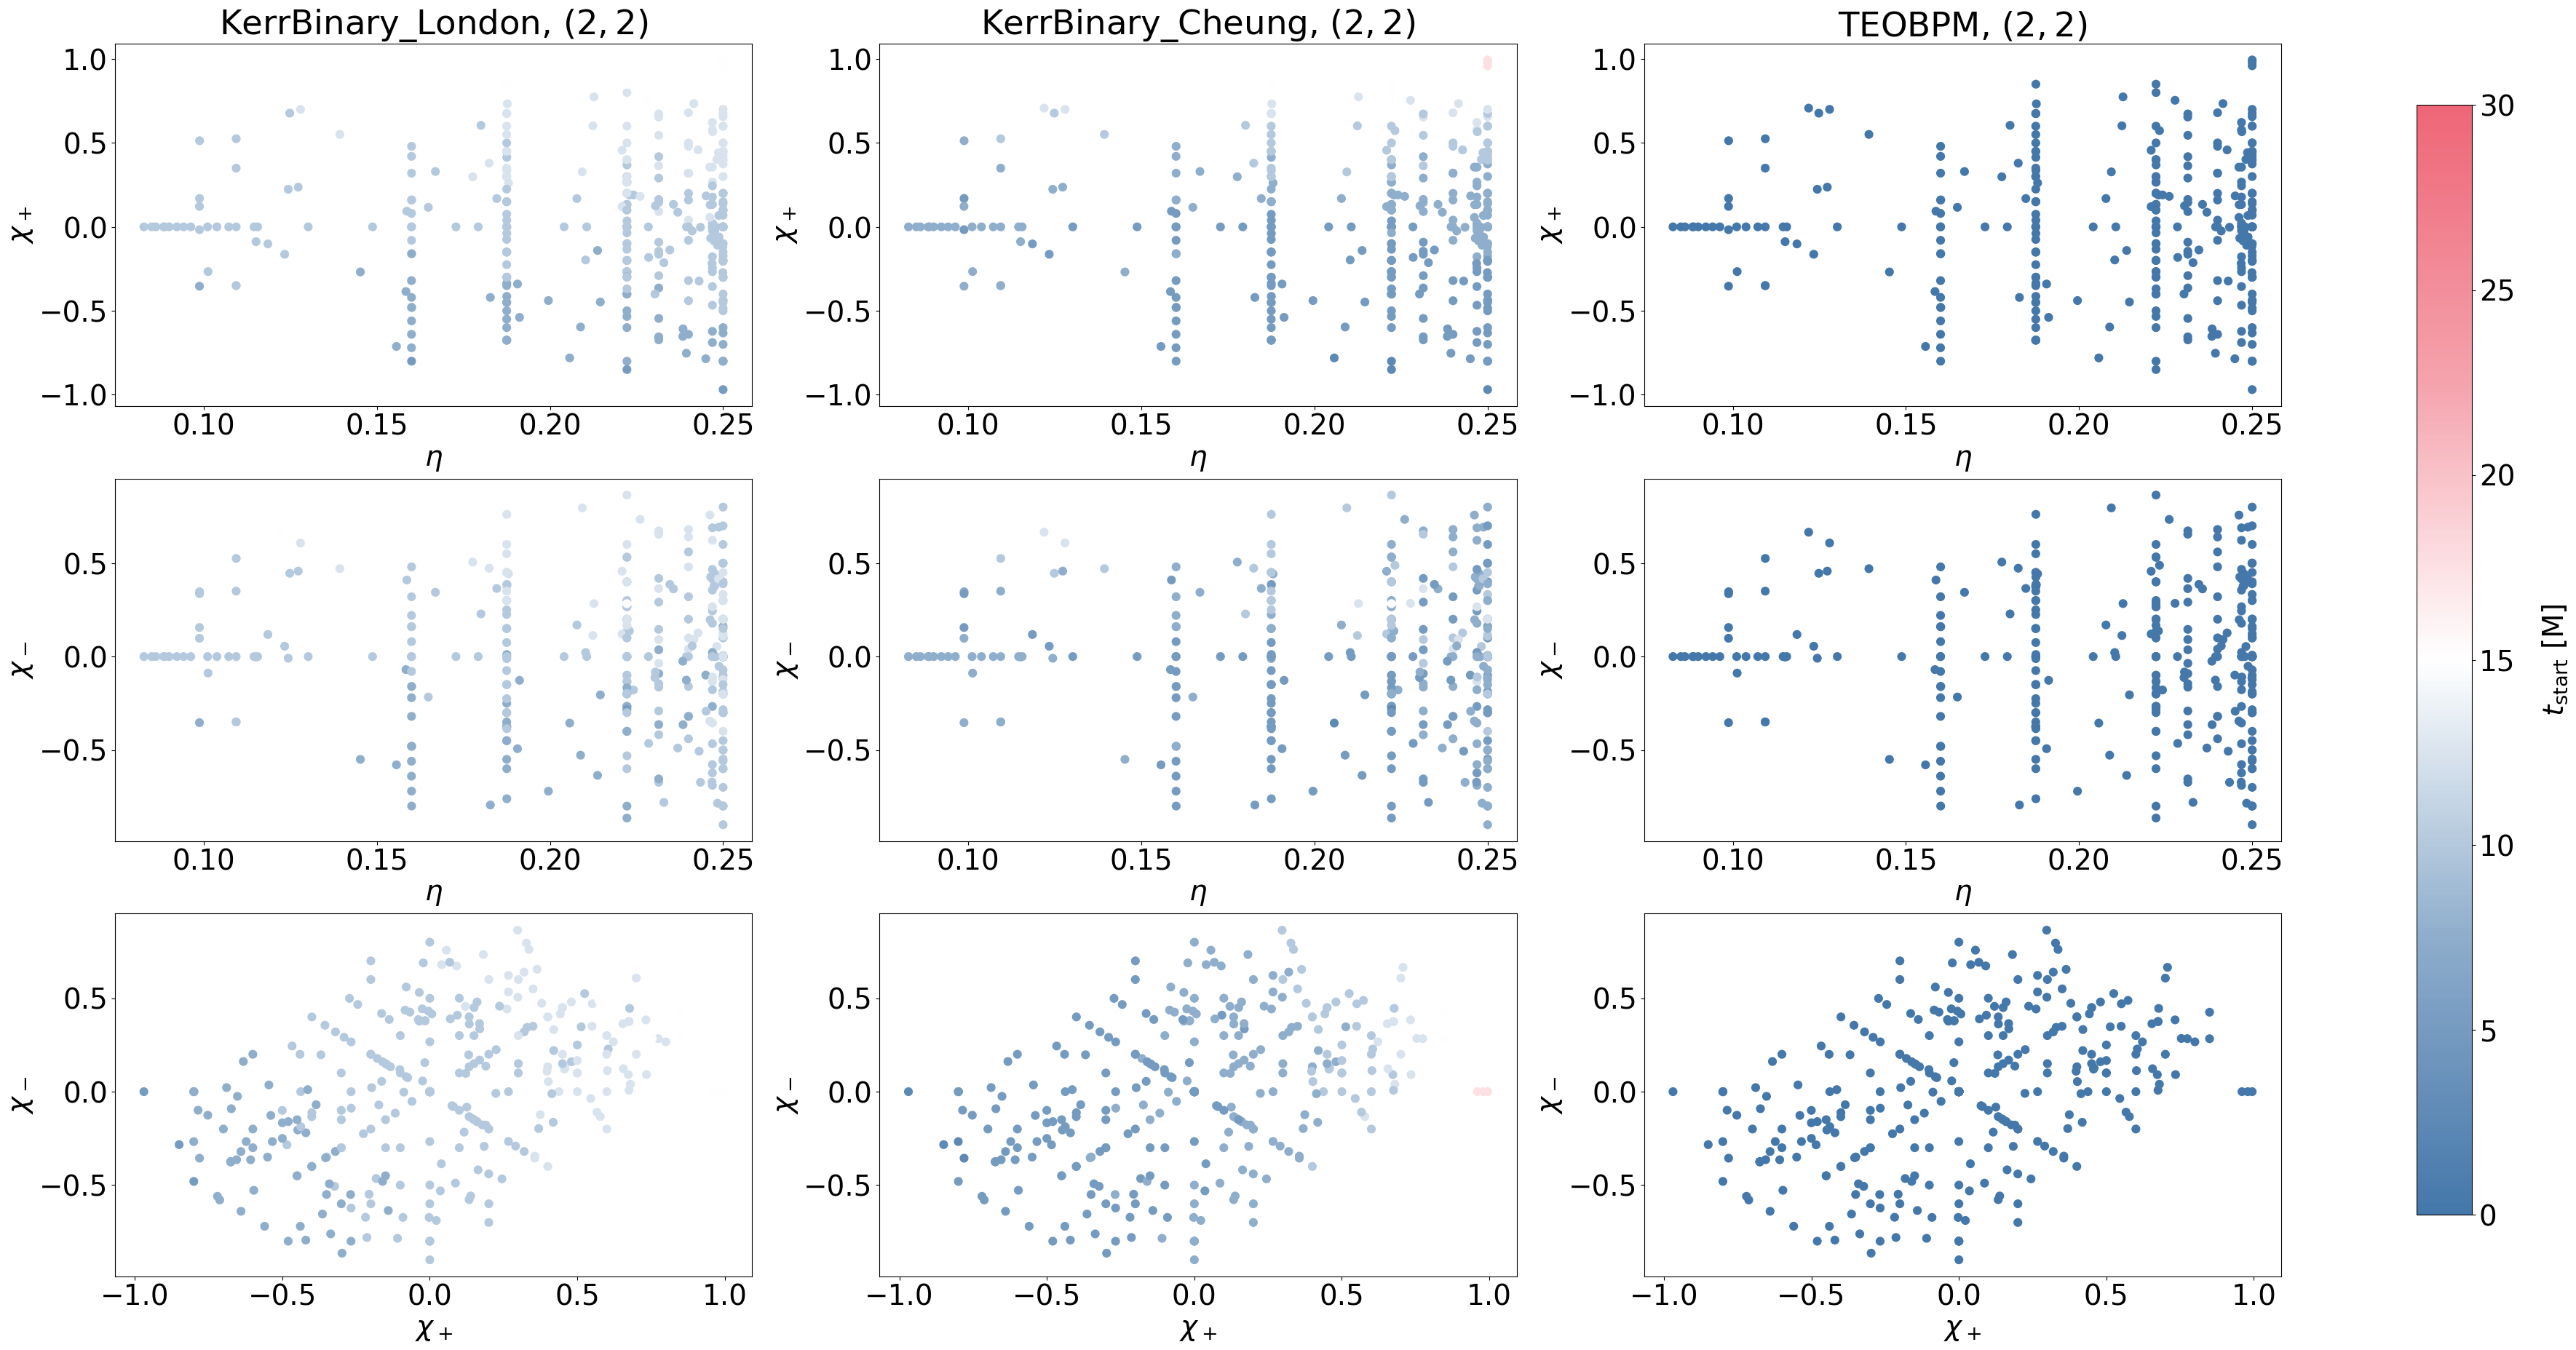

✅ Saved: starting_time_scatter_ellm_22_thresh_0.035.pdf


In [ ]:
# Define colormap utilities
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def lighten_color(rgb_color, factor):
    return tuple(c + (1 - c) * factor for c in rgb_color)

# Custom colormap
cmap = LinearSegmentedColormap.from_list(
    "enhanced", [
        hex_to_rgb("#4477AA"),
        lighten_color(hex_to_rgb("#4477AA"), 0.4),
        (1,1,1),
        lighten_color(hex_to_rgb("#EE6677"), 0.4),
        hex_to_rgb("#EE6677")
    ], 256
)

# Compute t_start for a simulation
def compute_t_start(sim_id, mode, threshold, start_times):
    ts, mm = [], []
    for t in start_times:
        v = avg_mismatches.get(model,{}).get(mode,{}).get(t,{}).get(sim_id,np.nan)
        if not np.isnan(v) and v > 0:
            ts.append(t)
            mm.append(v)
    if len(ts) < 2:
        return None
    ts, mm = np.array(ts), np.array(mm)

    # Return first time where mismatch <= threshold
    for t, m in zip(ts, mm):
        if m <= threshold:
            return t
    return None

# LaTeX axis labels
label_map = {"eta": r"\eta", "chip": r"\chi_+", "chim": r"\chi_-"}

# Available extraction times
start_times = sorted(float(t) for t in avg_mismatches[available_models[0]][mode].keys())
l_val, m_val = mode[0], mode[1]

# Loop over mismatch thresholds
for threshold in thresholds:

    fig, axs = plt.subplots(3, len(available_models), figsize=(16 * len(available_models), 22))

    for col, model in enumerate(available_models):
        records = []

        # Compute t_start for each simulation
        for sim, prm in id_info.items():
            t_s = compute_t_start(sim, mode, threshold, start_times)
            records.append({**prm, "t": t_s})

        df = pd.DataFrame(records)

        # Plot over parameter pairs
        for r, (x, y) in enumerate([("eta","chip"), ("eta","chim"), ("chip","chim")]):
            ax = axs[r][col]
            sc = ax.scatter(df[x], df[y], c=df["t"], cmap=cmap, vmin=0, vmax=30, s=60)

            ax.set_xlabel(f"${label_map[x]}$")
            ax.set_ylabel(f"${label_map[y]}$")

            if r == 0:
                ax.set_title(rf"{model}, $({l_val},{m_val})$")

    # Colorbar (Z-axis label)
    cbar = fig.colorbar(sc, ax=axs.ravel().tolist(), shrink=0.9)
    cbar.set_label(r"$t_{\rm start}$ [M]", rotation=90, labelpad=25)

    # Save figure
    outname = f"starting_time_scatter_ellm_{mode}_thresh_{threshold:.3f}.pdf"
    plt.savefig(outname)
    plt.show()
    plt.close()

    print(f"✅ Saved: {outname}")

